In [55]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras import initializers
from keras.models import load_model
from keras.constraints import UnitNorm
from keras import backend as K

In [56]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 11}

plt.rc('font', **font)

In [57]:
# the training data comes from a 
pend_data = np.load('halfoval.npy')

d_train=pend_data[:,0:10000,:,:]
d_test=pend_data[:,10000:-1,:,:]

In [58]:
#d_train=d_train[:,:,0,:]
d_train=d_train.reshape((128*10000, 51,2))
np.shape(d_train)

(1280000, 51, 2)

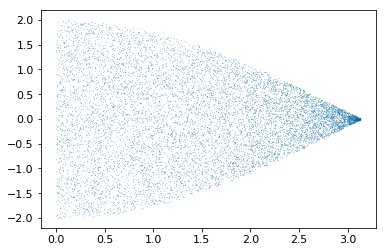

In [61]:
plt.scatter(d_train[0:10000,0,0], d_train[0:10000,0,1], s=0.01)

In [26]:
# this is the size of our encoded representations i.e. the width of the layers
encoding_dim = 80

# this is our input placeholder for the initial condition
input_dat = Input(shape=(2,))

# and we need another fifty placeholders for the trajectory
traject = []
for i in range(50):
    traject.append(Input(shape=(2,)))
    
# prepares the input list
combined_in = traject
combined_in.insert(0, input_dat)

# gives weights to l2 regularization
regularizer_weight = 1e-13

# initialization of weights following Lusch
a=1/np.sqrt(10)
init= initializers.TruncatedNormal(mean=0.0, stddev=a, seed=None)

# "encoded" is the encoded representation of the input, and we add hidden layers
HL_en1 = Dense(encoding_dim, 
                activation='relu',
                kernel_regularizer=regularizers.l2(regularizer_weight),
                #kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=1/2.8, seed=None),
                bias_initializer='zeros',
                use_bias=True)

HL_en2 = Dense(encoding_dim, 
                activation='relu',
                kernel_regularizer=regularizers.l2(regularizer_weight),
                #kernel_initializer=init,
                bias_initializer='zeros',
                use_bias=True)

encoded = Dense(encoding_dim, 
                activation='linear',
                kernel_regularizer=regularizers.l2(regularizer_weight),
                kernel_initializer=init,
                bias_initializer='zeros',
                use_bias=True)

# the koopman operator is supposed to just be a matrix, so biases are disabled
# also, if regularizers are turned on, eigenvalues on average take absolute values smaller than unity.
koopman = Dense(encoding_dim,
                activation='linear',
                #kernel_constraint= UnitNorm(axis=0),
                #kernel_regularizer=regularizers.l2(regularizer_weight),
                #kernel_initializer=init,
                use_bias=False)

# add hidden layers for decoding
HL_de1 = Dense(encoding_dim, 
              activation='relu',
              kernel_regularizer=regularizers.l2(regularizer_weight),
              #kernel_initializer=init,
              bias_initializer='zeros',
              use_bias=True)

HL_de2 = Dense(encoding_dim, 
              activation='relu',
              kernel_regularizer=regularizers.l2(regularizer_weight),
              #kernel_initializer=init,
              bias_initializer='zeros',
              use_bias=True)

# "decoded" is the reconstruction of the input
decoded = Dense(2,
                activation='linear',
                kernel_regularizer=regularizers.l2(regularizer_weight),
                use_bias=True)

In [27]:
# calculates the 1st, 2nd, ..., nth application of the Koopman layer (koopman^i(encoded))
# this corresponds to the arguments of L_pred in Lusch, 2018

K_ton=[encoded(HL_en2(HL_en1(input_dat)))]
for i in range(50):
    K_ton.append(koopman(K_ton[-1]))
    
# remove the first element which is just decoded(encoded(input))
K_ton.pop(0)

# decodes these data points to compare with actual trajectory
DK_ton=[]
for e in K_ton:
    DK_ton.append(decoded(HL_de2(HL_de1(e))))
len(DK_ton)

50

In [28]:
K=koopman.get_weights()
K=np.array(K)
K=K[0,:,:]
sigma=np.linalg.eig(K)
eigenvalue_mean=np.sum(np.absolute(np.array(sigma[0])))/len(sigma[0])

In [29]:
# we need an output list of the same dimension as inputs for the autoencoder to train
# the outputs include the initial condition encoded and decoded, as well as the outcome of 
# up to fifty applications of the koopman operator
combined_out=DK_ton
if len(combined_out)==50:
    combined_out.insert(0,decoded(HL_de2(HL_de1(encoded(HL_en2(HL_en1(input_dat)))))))
    #combined_out.insert(0,eigenvalue_mean)
len(combined_out)

51

In [30]:
# this model maps a trajectory to its projection based on the initial condition
autoencoder = Model(inputs=combined_in, outputs=combined_out  )

In [31]:
# to compile, prepare the weights given to different loss terms, 
# these are 1 for L_recon, 1/50 for each term in L_pred
weights=[0.02]*50
weights.insert(0, 5.)


# now we compile with this list of weights
autoencoder.compile(optimizer='adagrad', loss='mse', loss_weights=weights)

In [32]:
# before training, massage the data format a bit, as the model expects a list with 51
# arrays of dimension (trajectory_number, 2) each
t=d_train.transpose((1,0,2))
d=list(t)
# this means each element of the list d represents one time step. Each element combines all trajectories and
# two dimensions

In [33]:
autoencoder.fit(d,
                d,
                epochs=150,
                batch_size=128,
                shuffle=False,
                validation_split=0.05)

Train on 640000 samples, validate on 640000 samples
Epoch 1/60
640000/640000 [==============================] - 134s 209us/step - loss: 1624.3385 - dense_14_loss: 35670.4023 - val_loss: 0.7959 - val_dense_14_loss: 1.9567
Epoch 2/60
640000/640000 [==============================] - 126s 196us/step - loss: 0.7095 - dense_14_loss: 1.9409 - val_loss: 0.6365 - val_dense_14_loss: 1.9067
Epoch 3/60
640000/640000 [==============================] - 125s 196us/step - loss: 0.5781 - dense_14_loss: 1.8385 - val_loss: 0.5283 - val_dense_14_loss: 1.7712
Epoch 4/60
640000/640000 [==============================] - 125s 196us/step - loss: 0.4907 - dense_14_loss: 1.6953 - val_loss: 0.4565 - val_dense_14_loss: 1.6214
Epoch 5/60
640000/640000 [==============================] - 126s 197us/step - loss: 0.4315 - dense_14_loss: 1.5411 - val_loss: 0.4093 - val_dense_14_loss: 1.4780
Epoch 6/60
640000/640000 [==============================] - 126s 196us/step - loss: 0.3934 - dense_14_loss: 1.4224 - val_loss: 0.37

640000/640000 [==============================] - 125s 195us/step - loss: 0.1834 - dense_14_loss: 0.4608 - val_loss: 0.1822 - val_dense_14_loss: 0.4617
Epoch 51/60
640000/640000 [==============================] - 126s 196us/step - loss: 0.1820 - dense_14_loss: 0.4558 - val_loss: 0.1811 - val_dense_14_loss: 0.4560
Epoch 52/60
640000/640000 [==============================] - 125s 195us/step - loss: 0.1809 - dense_14_loss: 0.4500 - val_loss: 0.1800 - val_dense_14_loss: 0.4503
Epoch 53/60
640000/640000 [==============================] - 125s 195us/step - loss: 0.1798 - dense_14_loss: 0.4445 - val_loss: 0.1790 - val_dense_14_loss: 0.4448
Epoch 54/60
640000/640000 [==============================] - 126s 196us/step - loss: 0.1788 - dense_14_loss: 0.4391 - val_loss: 0.1780 - val_dense_14_loss: 0.4393
Epoch 55/60
640000/640000 [==============================] - 126s 197us/step - loss: 0.1778 - dense_14_loss: 0.4337 - val_loss: 0.1770 - val_dense_14_loss: 0.4338
Epoch 56/60
640000/640000 [=======

In [34]:
demo=np.load('demo.npy') #d_test=pend_data[:,10000:-1,:,:]
test=(demo[-1,0:7,:,:])
test=list(test[:,:,:].transpose(1,0,2))
#test=np.zeros((51,1,2))
#test[:,:,1]=1.9
#test=list(test)
np.shape(test)

(51, 7, 2)

In [35]:
p=autoencoder.predict(test)


Text(0, 0.5, 'x1: position, x2:velocity')

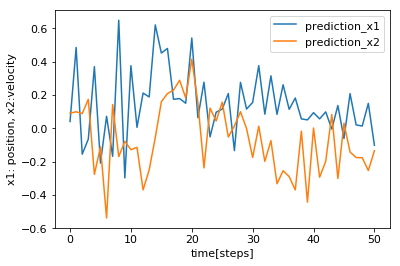

In [36]:
plt.plot(np.array(p)[:,0,:])
#plt.plot(np.array(p[:,0,:]).transpose())
plt.legend(['prediction_x1', 'prediction_x2', 'actual_x1', 'actual_x2'])
plt.xlabel("time[steps]")
plt.ylabel('x1: position, x2:velocity')

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51.]


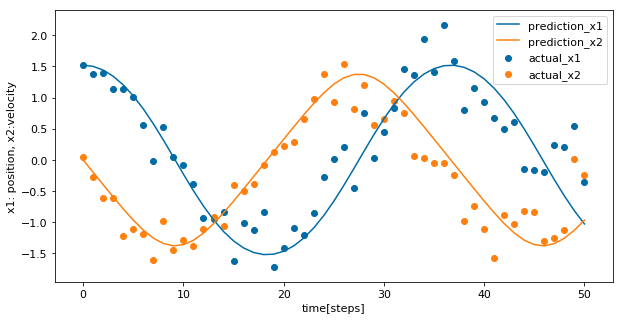

In [37]:
plt.figure(figsize=(10,5))
which=3
plt.style.use('tableau-colorblind10') 
np.array(p).transpose(1,0,2)[0,:,:]
plt.plot(demo[-1,which,:,:])
b=np.array(p).transpose(1,2,0)[which,:,:]
print(np.linspace(0,51,52))
plt.scatter(np.linspace(0,50, 51),b[0])
plt.scatter(np.linspace(0,50, 51),b[1])
plt.legend(['prediction_x1', 'prediction_x2', 'actual_x1', 'actual_x2'], loc=1)
plt.xlabel("time[steps]")
plt.ylabel('x1: position, x2:velocity')
#print(np.array(p).transpose(1,0,2)[0,:,:])
plt.savefig('pred_res_naive_onetraj', dpi=200)

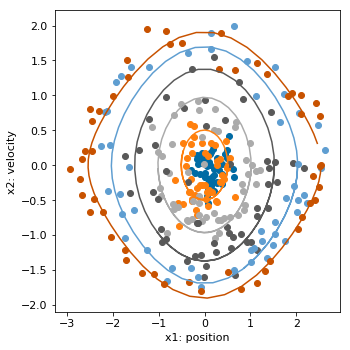

In [38]:
plt.figure(figsize=(5,5))
#plt.style.use('seaborn-white')   
plt.style.use('tableau-colorblind10')   
for which in range(6):
    d=np.array(p).transpose(1,2,0)[which,:,:]
    plt.scatter(d[0], d[1], marker='o', label='le')
    r=demo[-1,which,:,:]
    r=np.array(r).transpose()
    plt.plot(r[0], r[1], label='la')
#plt.legend('label','le')
plt.xlabel("x1: position")
plt.ylabel('x2: velocity')
#print(np.array(p).transpose(1,0,2)[0,:,:])
plt.tight_layout()
plt.savefig('pred_res_naive', dpi=200)

In [39]:
demo=np.load('pend_dat.npy')
demo=demo[:,10000:15000,:,:]
demo=demo.reshape((128*5000, 51,2))
test=demo
test=list(test[:,:,:].transpose(1,0,2))
#test=np.zeros((51,1,2))
#test[:,:,1]=1.9
#test=list(test)
np.shape(test)


(51, 640000, 2)

In [40]:
p=autoencoder.predict(test)

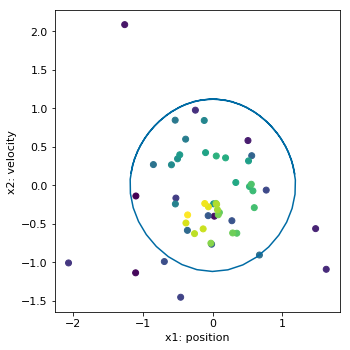

In [41]:
plt.figure(figsize=(5,5))
which=10110
plt.scatter(np.array(p)[:,which,0], np.array(p)[:,which,1], c=np.linspace(0,4000,51), cmap='viridis')
plt.plot(np.array(test)[:,which,0], np.array(test)[:,which,1])
plt.xlabel("x1: position")
plt.ylabel('x2: velocity')
#print(np.array(p).transpose(1,0,2)[0,:,:])
plt.tight_layout()
plt.savefig('fail_pred_naive_spiral_in', dpi=200)

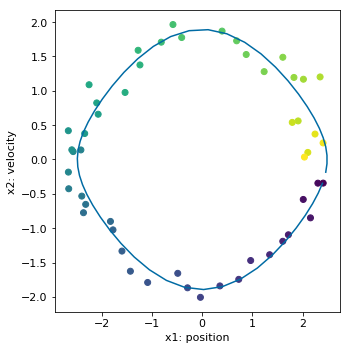

In [42]:
plt.figure(figsize=(5,5))
which=10122
plt.scatter(np.array(p)[:,which,0], np.array(p)[:,which,1], c=np.linspace(0,4000,51), cmap='viridis')
plt.plot(np.array(test)[:,which,0], np.array(test)[:,which,1])
plt.xlabel("x1: position")
plt.ylabel('x2: velocity')
plt.tight_layout()

#print(np.array(p).transpose(1,0,2)[0,:,:])
#plt.savefig('fail_pred_naive_spiral_in', dpi=200)

[ 2.68868185  0.25438258  2.36646297 ...  0.44779715 -0.80461262
 -1.79549194]
121652694.01257288


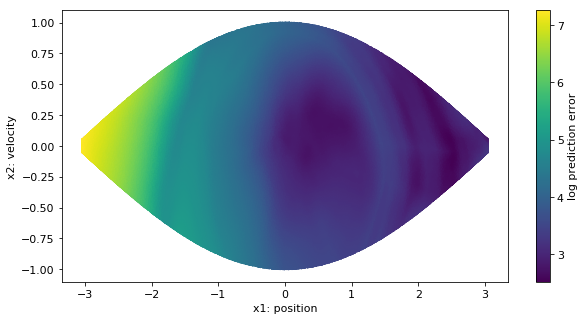

In [43]:
plt.figure(figsize=(10,5))
plt.style.use('tableau-colorblind10')   
a=np.abs(np.subtract(np.array(test), np.array(p)))
print(test[0][:,0])
a=np.sum(a, axis=(0,2))
print(np.sum(a))
plt.scatter(test[0][:,0], test[0][:,1], c=np.log(a), cmap='viridis', s=1)
plt.colorbar(label="log prediction error")
plt.xlabel("x1: position")
plt.ylabel('x2: velocity')
plt.savefig("pred_map_naive",dpi=300)

In [44]:
print(np.sum(a)/640000)

190.08233439464513


In [45]:
K=koopman.get_weights()
K=np.array(K)
K=K[0,:,:]
sigma=np.linalg.eig(K)
np.sum(np.absolute(np.array(sigma[0])))/len(sigma[0])

0.666401481628418

In [46]:
len(sigma[0])

80

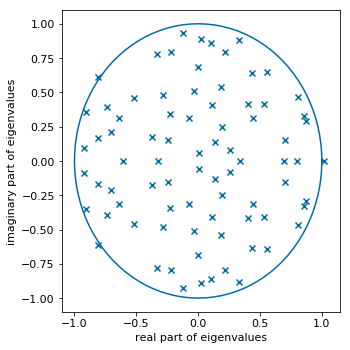

In [47]:
plt.figure(figsize=(5,5))
towhere=80
t = np.linspace(0,2*np.pi,101)
plt.plot(np.cos(t),np.sin(t))
plt.scatter(sigma[0][0:towhere].real,sigma[0][0:towhere].imag, marker='x')
#plt.scatter(np.log(sigma[0][0:towhere]).real,np.log(sigma[0][0:towhere]).imag, marker='x')
plt.xlabel("real part of eigenvalues")
plt.ylabel("imaginary part of eigenvalues")
plt.tight_layout()
plt.savefig("eigenvalue spectrum", dpi=200)

In [48]:
#d=np.zeros(80)
for i in range(500,1000):
    get_3rd_layer_output = K.function([autoencoder.layers[0].input],
                                  [autoencoder.layers[2].get_output_at(0)])
    d+=get_3rd_layer_output(np.array(test)[:,0,:])[0][0]


AttributeError: 'numpy.ndarray' object has no attribute 'function'

In [ ]:
plt.figure(figsize=(10,5))
sort=np.sort(d)
#plt.plot(sort[::-1])
plt.scatter(np.linspace(1,80,80),sort[::-1]/1000)
plt.xlabel("transformed input number")
plt.ylabel("average transf. input size")
plt.savefig("transformed", dpi=200)

In [ ]:
# why the short time interval lusch et al use? 

# do decoded() and encoded() count as hidden layers in the sense that 
# lusch et al say they use two hidden layers in the encoder and decoder?

# any more elegant way than the lists I used for inputs and outputs?

In [ ]:
autoencoder.save('50epochs_savemodel.h5')
autoencoder.save_weights('50epochs_saveweights.h5')

In [ ]:
old_ae=load_model('50epochs_savemodel.h5')
old_ae.load_weights('50epochs_saveweights.h5')

In [ ]:
test=(d_test[-1,0:10,:,:])
test=list(test[:,:,:].transpose(1,0,2))
np.shape(test)
#old_ae.summary()
p=old_ae.predict(np.array([[0.5,0.2],[0.4,0.1]]))

In [ ]:
k=koopman.get_weights()
k=np.array(k)
k=k[0,:,:]
k.shape
pigma=np.linalg.eig(k)
np.array(pigma[0])

In [ ]:
L=old_ae.layers[4].get_weights()

In [ ]:
L